**Traffic Sign Classification Transfer Learning Application**

Traffic sign classification is the process of automatically recognizing traffic signs along the road. The code below uses pre-trained VGG and dense model to train the model. The dataset is from German Traffic Sign Recognition Benchmark (GTSRB).

In [0]:
### Importing images from kaggle ###
%tensorflow_version 2.x
#!kill -9 -1

!pip install kaggle
!mkdir .kaggle
!mkdir traffic-sign
import json
token = {"username":"XXX","key":"XXX"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v /content
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets list
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
!mv /content/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/gtsrb-german-traffic-sign.zip /content/traffic-sign
!unzip /content/traffic-sign/gtsrb-german-traffic-sign.zip

In [0]:
!nvidia-smi

Tue Feb 25 09:34:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    33W / 250W |    265MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# Read Data
import pandas as pd
import glob
import os

train_path = "/content/train"

data = []
for root, dirs, files in os.walk(train_path, topdown=True):
  for name in files:
    if '.png' in name:
      filename = os.path.abspath(os.path.join(root, name))
      class_name = os.path.basename(root)
      data.append((filename, class_name))

df = pd.DataFrame(data, columns=['filename', 'class'])
class_name_type = ['Speed limit (20km/h)','Speed limit (30km/h)','Speed limit (50km/h)','Speed limit (60km/h)','Speed limit (70km/h)','Speed limit (80km/h)','End of speed limit (80km/h)','Speed limit (100km/h)','Speed limit (120km/h)','No passing','No passing veh over 3.5 tons','Right-of-way at intersection','Priority road','Yield','Stop','No vehicles','Veh > 3.5 tons prohibited','No entry','General caution','Dangerous curve left','Dangerous curve right','Double curve','Bumpy road','Slippery road','Road narrows on the right','Road work','Traffic signals','Pedestrians','Children crossing','Bicycles crossing','Beware of ice/snow','Wild animals crossing','End speed + passing limits','Turn right ahead','Turn left ahead','Ahead only','Go straight or right','Go straight or left','Keep right','Keep left','Roundabout mandatory','End of no passing','End no passing veh > 3.5 tons']
df['class'] = df['class'].apply(lambda x: int(x))
df['class_name'] = df['class'].apply(lambda x: class_name_type[x])

#shuffle
df = df.sample(frac=1).reset_index(drop=True)

In [0]:
# Split into train and validation sets
train_set_percentage = .9

# Training Data Set 90%
df = df[:int(len(df)*train_set_percentage)]
# Validation Data Set 10%
df_val = df[int(len(df)*train_set_percentage):]

# shuffle 
df = df.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)

In [0]:
# Reads an image from a file, decodes it into a tensor, and resizes it
# to a fixed shape.
img_rows, img_cols = 224,224
num_classes = 43
batch_size = 32

def _parse_function(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string,channels=3)
  image_resized = tf.image.resize(image_decoded, [img_rows, img_cols])
  image_resized = tf.ensure_shape(image_resized ,shape=(img_rows, img_cols,3))
  label = tf.one_hot(label, num_classes)
  return image_resized, label

In [0]:
# Assemble the Data pipeline using tf.data
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model,load_model,Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input
from tensorflow.keras import backend as K
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df['filename'].values, tf.string),
                                                    tf.cast(df['class'].values, tf.int32) ))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.shuffle(5000)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

valid_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_val['filename'].values, tf.string),
                                                    tf.cast(df_val['class'].values, tf.int32) ))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.shuffle(5000)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(batch_size, drop_remainder=True)

In [0]:
# API to create pre-trained model
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3),pooling=None)

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
# add a global spatial average pooling layer
x = base_model.output

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

#x = Dropout(0.3)(x)

# and a logits layer -- let's say we have 42 classes
predictions = Dense(43, activation='softmax')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [0]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional VGG16 layers
for layer in base_model.layers:
    print(layer.name)
    layer.trainable = False

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [0]:
for layer in model.layers:
    print(layer.name,' Trainable =',layer.trainable)

input_1  Trainable = False
block1_conv1  Trainable = False
block1_conv2  Trainable = False
block1_pool  Trainable = False
block2_conv1  Trainable = False
block2_conv2  Trainable = False
block2_pool  Trainable = False
block3_conv1  Trainable = False
block3_conv2  Trainable = False
block3_conv3  Trainable = False
block3_pool  Trainable = False
block4_conv1  Trainable = False
block4_conv2  Trainable = False
block4_conv3  Trainable = False
block4_pool  Trainable = False
block5_conv1  Trainable = False
block5_conv2  Trainable = False
block5_conv3  Trainable = False
block5_pool  Trainable = False
global_average_pooling2d  Trainable = True
dense  Trainable = True
dense_1  Trainable = True


In [0]:
opt = tf.keras.optimizers.Adam(lr=0.001)

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
train_steps = int(len(df)/32) #total trains set / batch_size
val_steps = int(len(df_val)/32)
epochs = 10

print('train steps:',train_steps)
print('val steps:',val_steps)

train steps: 1102
val steps: 110


In [0]:
# Callback
from keras.callbacks import ModelCheckpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

Using TensorFlow backend.


In [0]:
### Train the model with validation and Callback 
history = model.fit( train_dataset, 
                    steps_per_epoch = train_steps,
                   epochs = epochs,
                    callbacks=callbacks_list,
                   validation_data = valid_dataset,
                   validation_steps = val_steps)

Train for 1102 steps, validate for 110 steps
Epoch 1/10
1101/1102 [============================>.] - ETA: 0s - loss: 0.6644 - accuracy: 0.8162
Epoch 00001: val_accuracy improved from -inf to 0.92869, saving model to weights.best.hdf5
1102/1102 [==============================] - 111s 100ms/step - loss: 0.6640 - accuracy: 0.8164 - val_loss: 0.2365 - val_accuracy: 0.9287
Epoch 2/10
1101/1102 [============================>.] - ETA: 0s - loss: 0.2063 - accuracy: 0.9377
Epoch 00002: val_accuracy improved from 0.92869 to 0.95341, saving model to weights.best.hdf5
1102/1102 [==============================] - 98s 89ms/step - loss: 0.2063 - accuracy: 0.9377 - val_loss: 0.1423 - val_accuracy: 0.9534
Epoch 3/10
1101/1102 [============================>.] - ETA: 0s - loss: 0.1513 - accuracy: 0.9540
Epoch 00003: val_accuracy improved from 0.95341 to 0.97756, saving model to weights.best.hdf5
1102/1102 [==============================] - 98s 89ms/step - loss: 0.1513 - accuracy: 0.9541 - val_loss: 0.080

In [0]:
metrics = model.evaluate(valid_dataset,
                   steps = val_steps)
print("Model Accuracy is:",metrics[1])

110/110 [==============================] - 12s 109ms/step - loss: 0.0467 - accuracy: 0.9858
Model Accuracy is: 0.98579544


**Test out the Traffic Sign Classification Model**

In [0]:
from IPython.display import display, Image
from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
import numpy as np

def resize_image(image_check):
  img_path = image_check
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  return x

def ts_pred(x):
  x = resize_image(x)
  preds = model.predict(x)
  output = pd.DataFrame(preds,columns=class_name_type)
  output = output.transpose()
  output = output.sort_values(by=0, ascending=False).rename(columns={0:'Prediction'})
  print(output.round(5)[0:5])

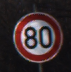

                              Prediction
Speed limit (80km/h)             0.85848
Speed limit (50km/h)             0.13114
No passing veh over 3.5 tons     0.00993
Speed limit (30km/h)             0.00023
Turn left ahead                  0.00011


In [0]:
image_check = '/content/test/02246.png'
display(Image(image_check))
ts_pred(image_check)

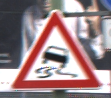

                       Prediction
Slippery road                 1.0
Bumpy road                    0.0
Road work                     0.0
Dangerous curve right         0.0
General caution               0.0


In [0]:
image_check = '/content/test/12564.png'
display(Image(image_check))
ts_pred(image_check)

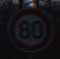

                              Prediction
Speed limit (80km/h)             0.97173
No passing veh over 3.5 tons     0.02826
Speed limit (100km/h)            0.00000
Speed limit (70km/h)             0.00000
Speed limit (60km/h)             0.00000


In [0]:
image_check = '/content/test/11443.png'
display(Image(image_check))
ts_pred(image_check)

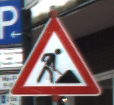

                       Prediction
Road work                     1.0
Double curve                  0.0
Dangerous curve right         0.0
Traffic signals               0.0
General caution               0.0


In [0]:
image_check = '/content/test/12314.png'
display(Image(image_check))
ts_pred(image_check)

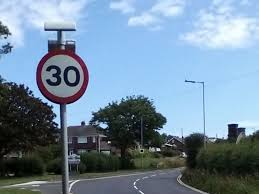

                       Prediction
Speed limit (30km/h)      0.99837
Beware of ice/snow        0.00089
Speed limit (120km/h)     0.00062
Children crossing         0.00005
Speed limit (70km/h)      0.00003


In [0]:
image_check = '/content/3.jpg'
display(Image(image_check))
ts_pred(image_check)